# Diamonds Evaluation Task
TODO

In [1]:
import os
import random

import pickle
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import f_oneway
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Importing, preprocessing and cleaning of the dataset
Observe the dataset to understand if there are value that can cause problems for the model

Import the dataset with pandas and verify that is completely load into a dataframe

In [2]:
df = pd.read_csv(os.path.join('../datasets/diamonds/diamonds.csv'))
print(df)

      carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30      Ideal     H    VVS1   61.2   57.0    655  4.30  4.39  2.66

[5000 rows x 10 columns]


Let's start by looking at the columns that represent numerical features so that we can see if there are any inconsistencies, data we don't need or need to remove, and begin to understand possible relationships between them

In [3]:
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


We then proceed to analyze the categorical features to see here, too, if there are values that we do not expect (possible clarity, color, or cut parameters that do not exist, do not make sense or are not present in the diamond documentation)

In [4]:
print(df['cut'].value_counts())
print(df['color'].value_counts())
print(df['clarity'].value_counts())

cut
Ideal        1992
Premium      1294
Very Good    1099
Good          457
Fair          158
Name: count, dtype: int64
color
G    1097
E     918
F     844
H     767
D     608
I     517
J     249
Name: count, dtype: int64
clarity
SI1     1194
VS2     1136
SI2      845
VS1      801
VVS2     464
VVS1     346
IF       150
I1        64
Name: count, dtype: int64


Check if there are some null value between all the features

In [5]:
print(df.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Not always the null value are present as 'null'. Since there are some diamonds that have a price equal to '-1' and thus they have not been evaluated, we check how many there are and if there are few we take them out since they will not be useful for training

In [6]:
(df['price'] <= 0).sum()

10

In [7]:
df = df[df['price'] >= 0]

We also saw that x, y, and z have as their minimum value 0, since a diamond that has no dimensions does not exist and there is no point in evaluating it, we observe whether they are 0 all in the same row, in that case we remove it

In [8]:
print((df['x'] <= 0).sum())
print((df['y'] <= 0).sum())
print((df['z'] <= 0).sum())

1
1
1


In [9]:
row_with_no_dimensions = df[(df['x'] <= 0) | (df['y'] <= 0) | (df['z'] <= 0)]

In [10]:
print(row_with_no_dimensions)

      carat      cut color clarity  depth  table  price    x    y    z
4321   2.25  Premium     H     SI2   62.8   59.0  18034  0.0  0.0  0.0


In [11]:
df = df.drop(row_with_no_dimensions.index)

Having removed 10 rows without the price and one row without the dimensions, so 11 rows, we should find ourselves in having 5000-11= 4989 rows

In [12]:
df.count()

carat      4989
cut        4989
color      4989
clarity    4989
depth      4989
table      4989
price      4989
x          4989
y          4989
z          4989
dtype: int64

# Plotting some column to observe ranges and values

We have three categorical features that are:
1. **cut**: a grade, an objective assessment of a diamond's light performance, expressed in words (ideal, very good, ...)
2. **color**: a letter (in order from 'D' to 'Z') that express the color of the diamond, from Colorless to Light Yellow
3. **clarity**: a scale that represent the imperfections, or inclusions, on and in the diamond, from IF (internally flawless) to I1 (included)

The numerical features are seven and they represent the dimension of the diamond (**x**, **y** and **z**), the dimension of the **table** and the lower body under the table (**depth**). There is also the **carat** that is the unit of mass as 1 carat = 200 mg ans the price, the evaluation posed by the expert

In [13]:
categorical_features = ['cut', 'color', 'clarity']
numerical_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

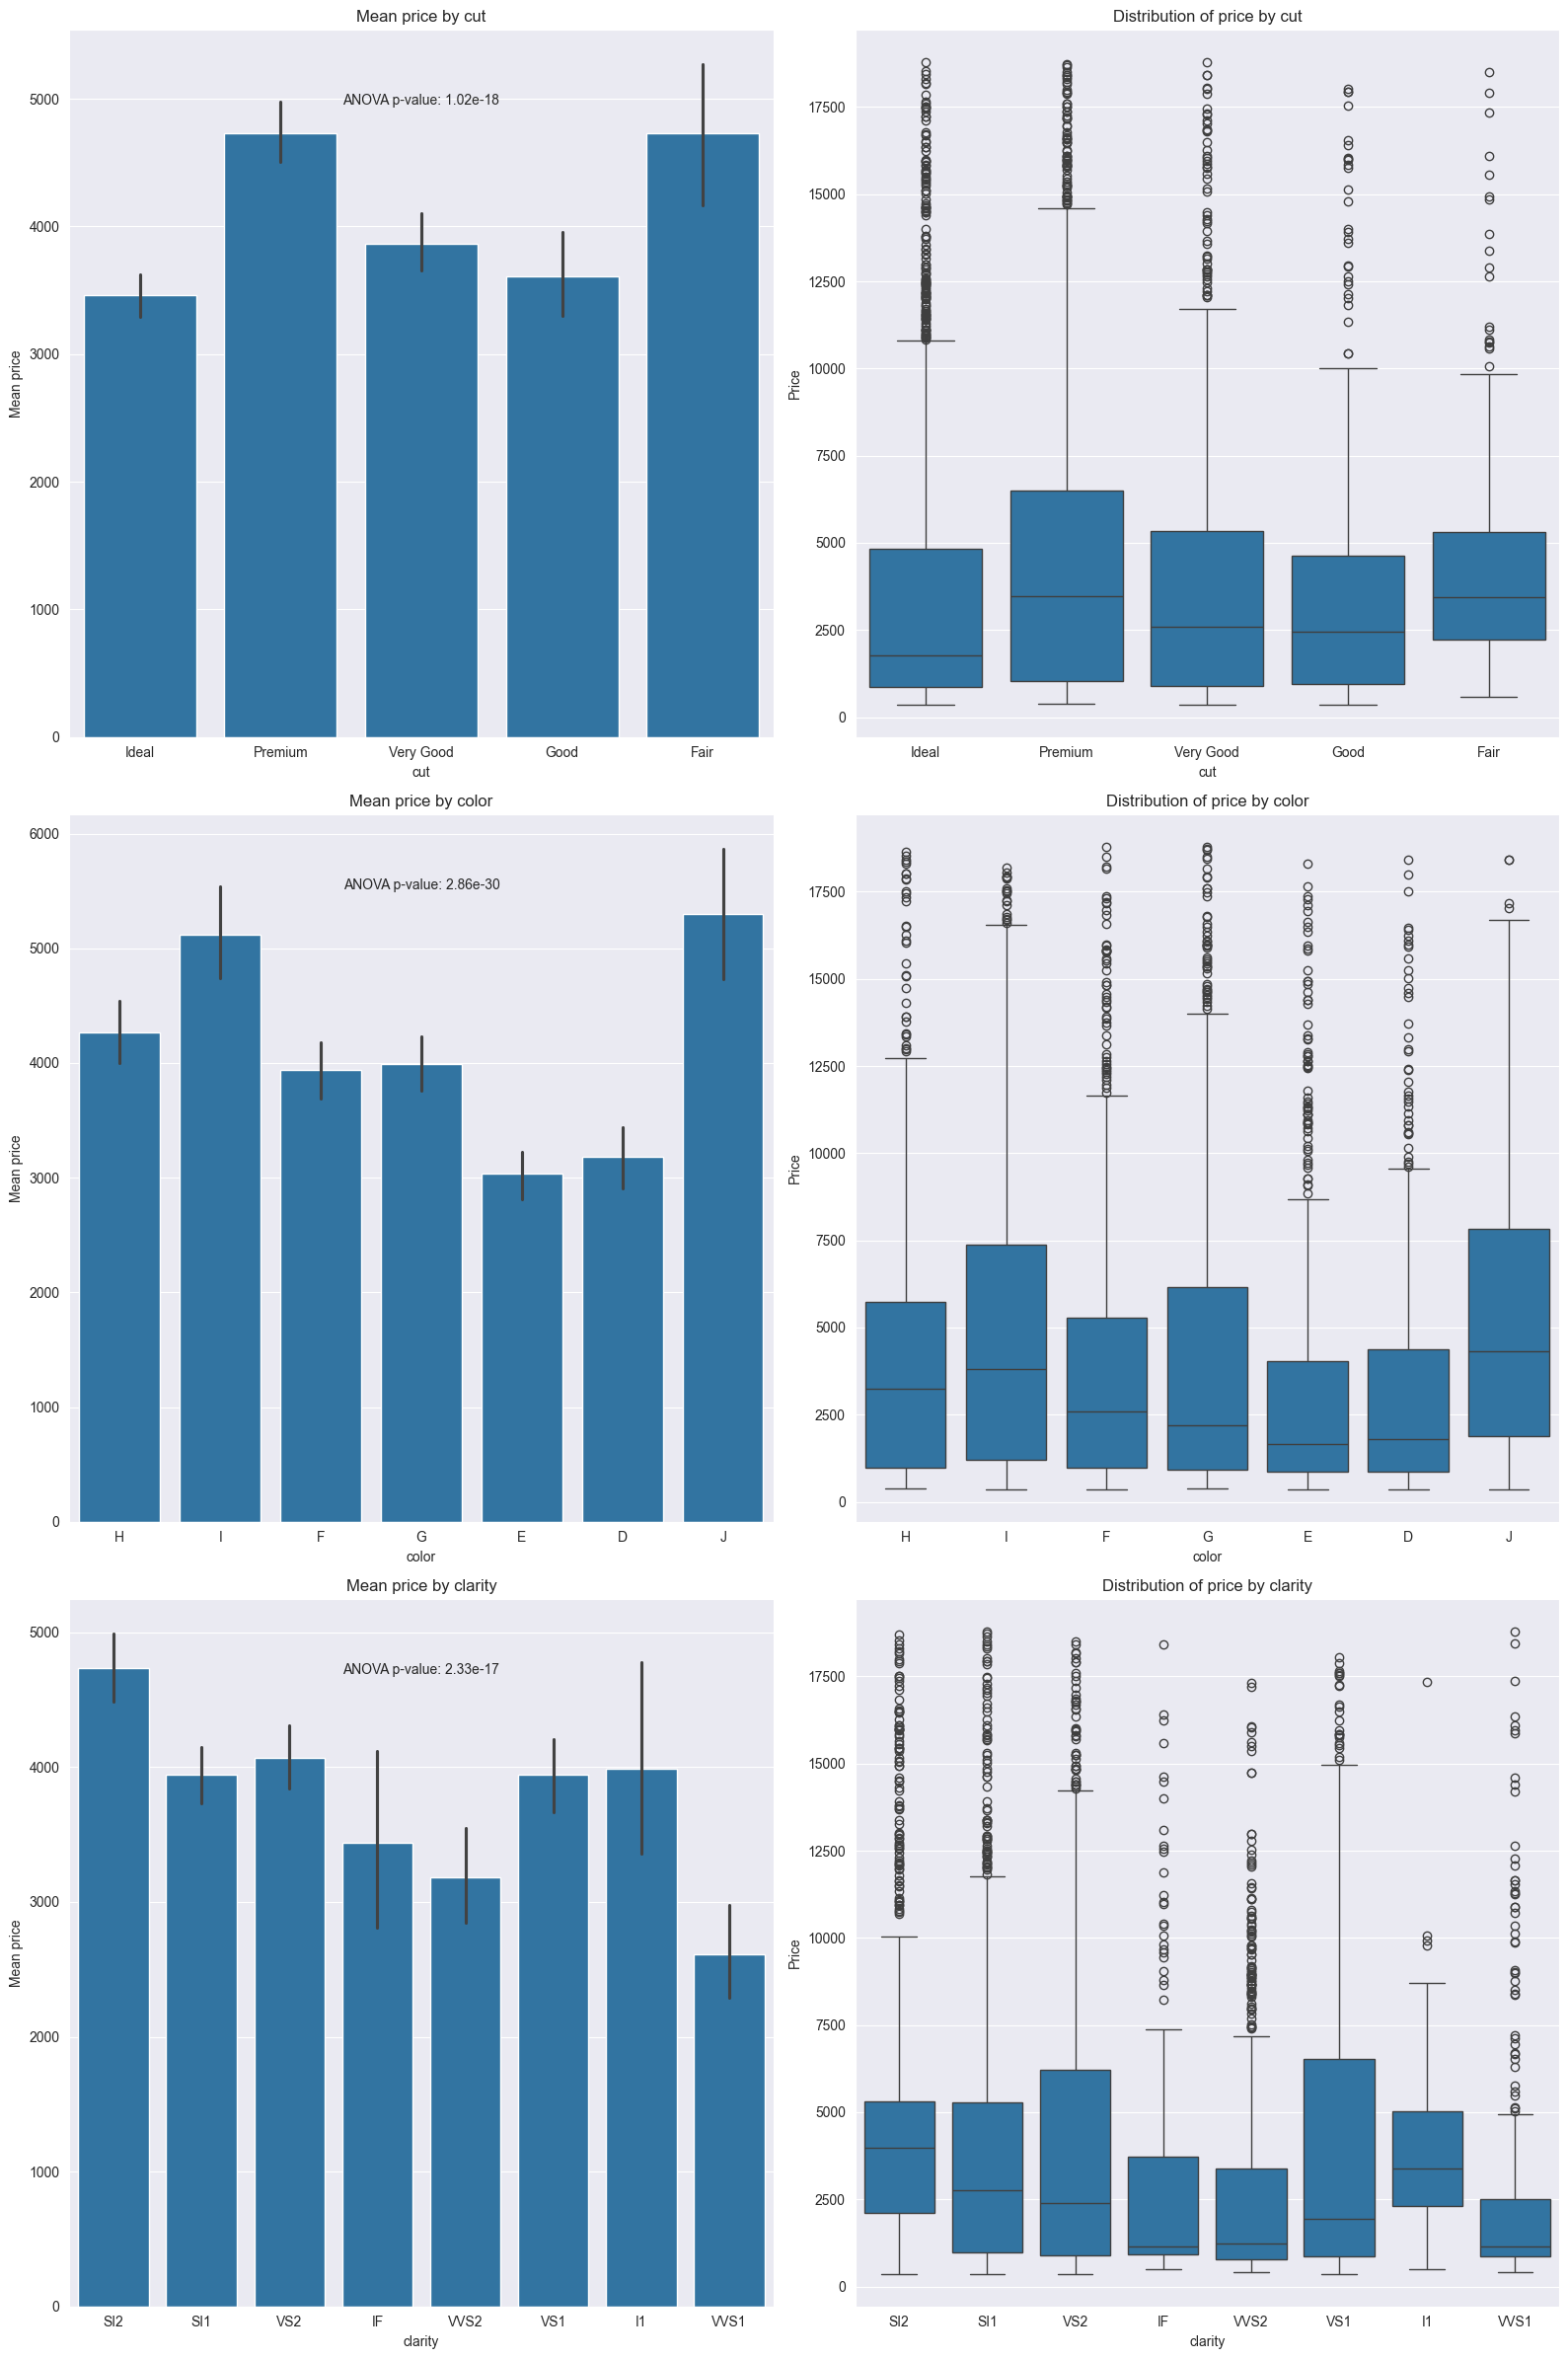

In [14]:
# Define the target feature
target_feature = 'price'

# Create subplots
fig, axes = plt.subplots(len(categorical_features), 2, figsize=(16, 8*len(categorical_features)))

# Loop through categorical features
for i, feature in enumerate(categorical_features):
    # Bar plot showing the mean of the target variable for each category
    sns.barplot(data=df, x=feature, y=target_feature, ax=axes[i, 0])
    axes[i, 0].set_title(f'Mean {target_feature} by {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel(f'Mean {target_feature}')

    # Box plot showing the distribution of the target variable for each category
    sns.boxplot(data=df, x=feature, y='price', ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution of {target_feature} by {feature}')
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel('Price')

    # Statistical test (ANOVA) to assess significance of relationship
    groups = df.groupby(feature)['price'].apply(list)
    f_statistic, p_value = f_oneway(*groups)
    axes[i, 0].text(0.5, 0.9, f"ANOVA p-value: {p_value:.2e}", horizontalalignment='center', verticalalignment='center', transform=axes[i, 0].transAxes)

# Adjust layout
plt.tight_layout()
plt.show()

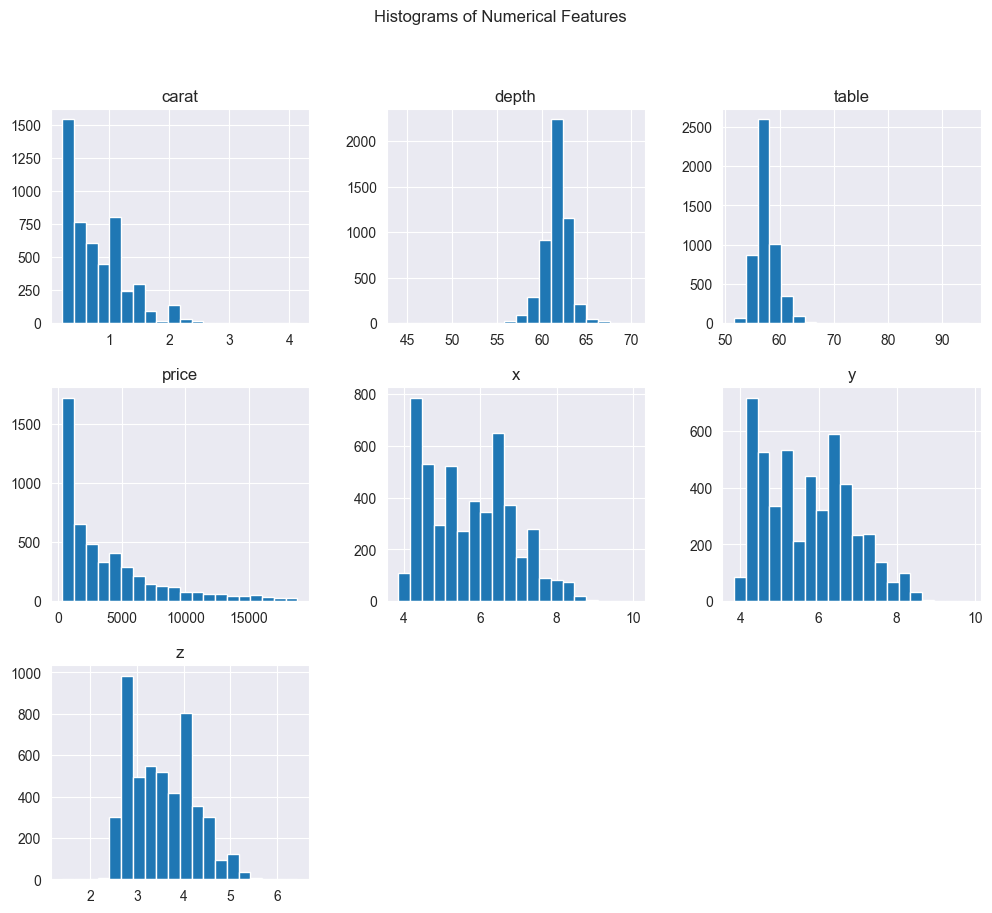

In [15]:
# Histograms of numerical features
df[numerical_features].hist(bins=20, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

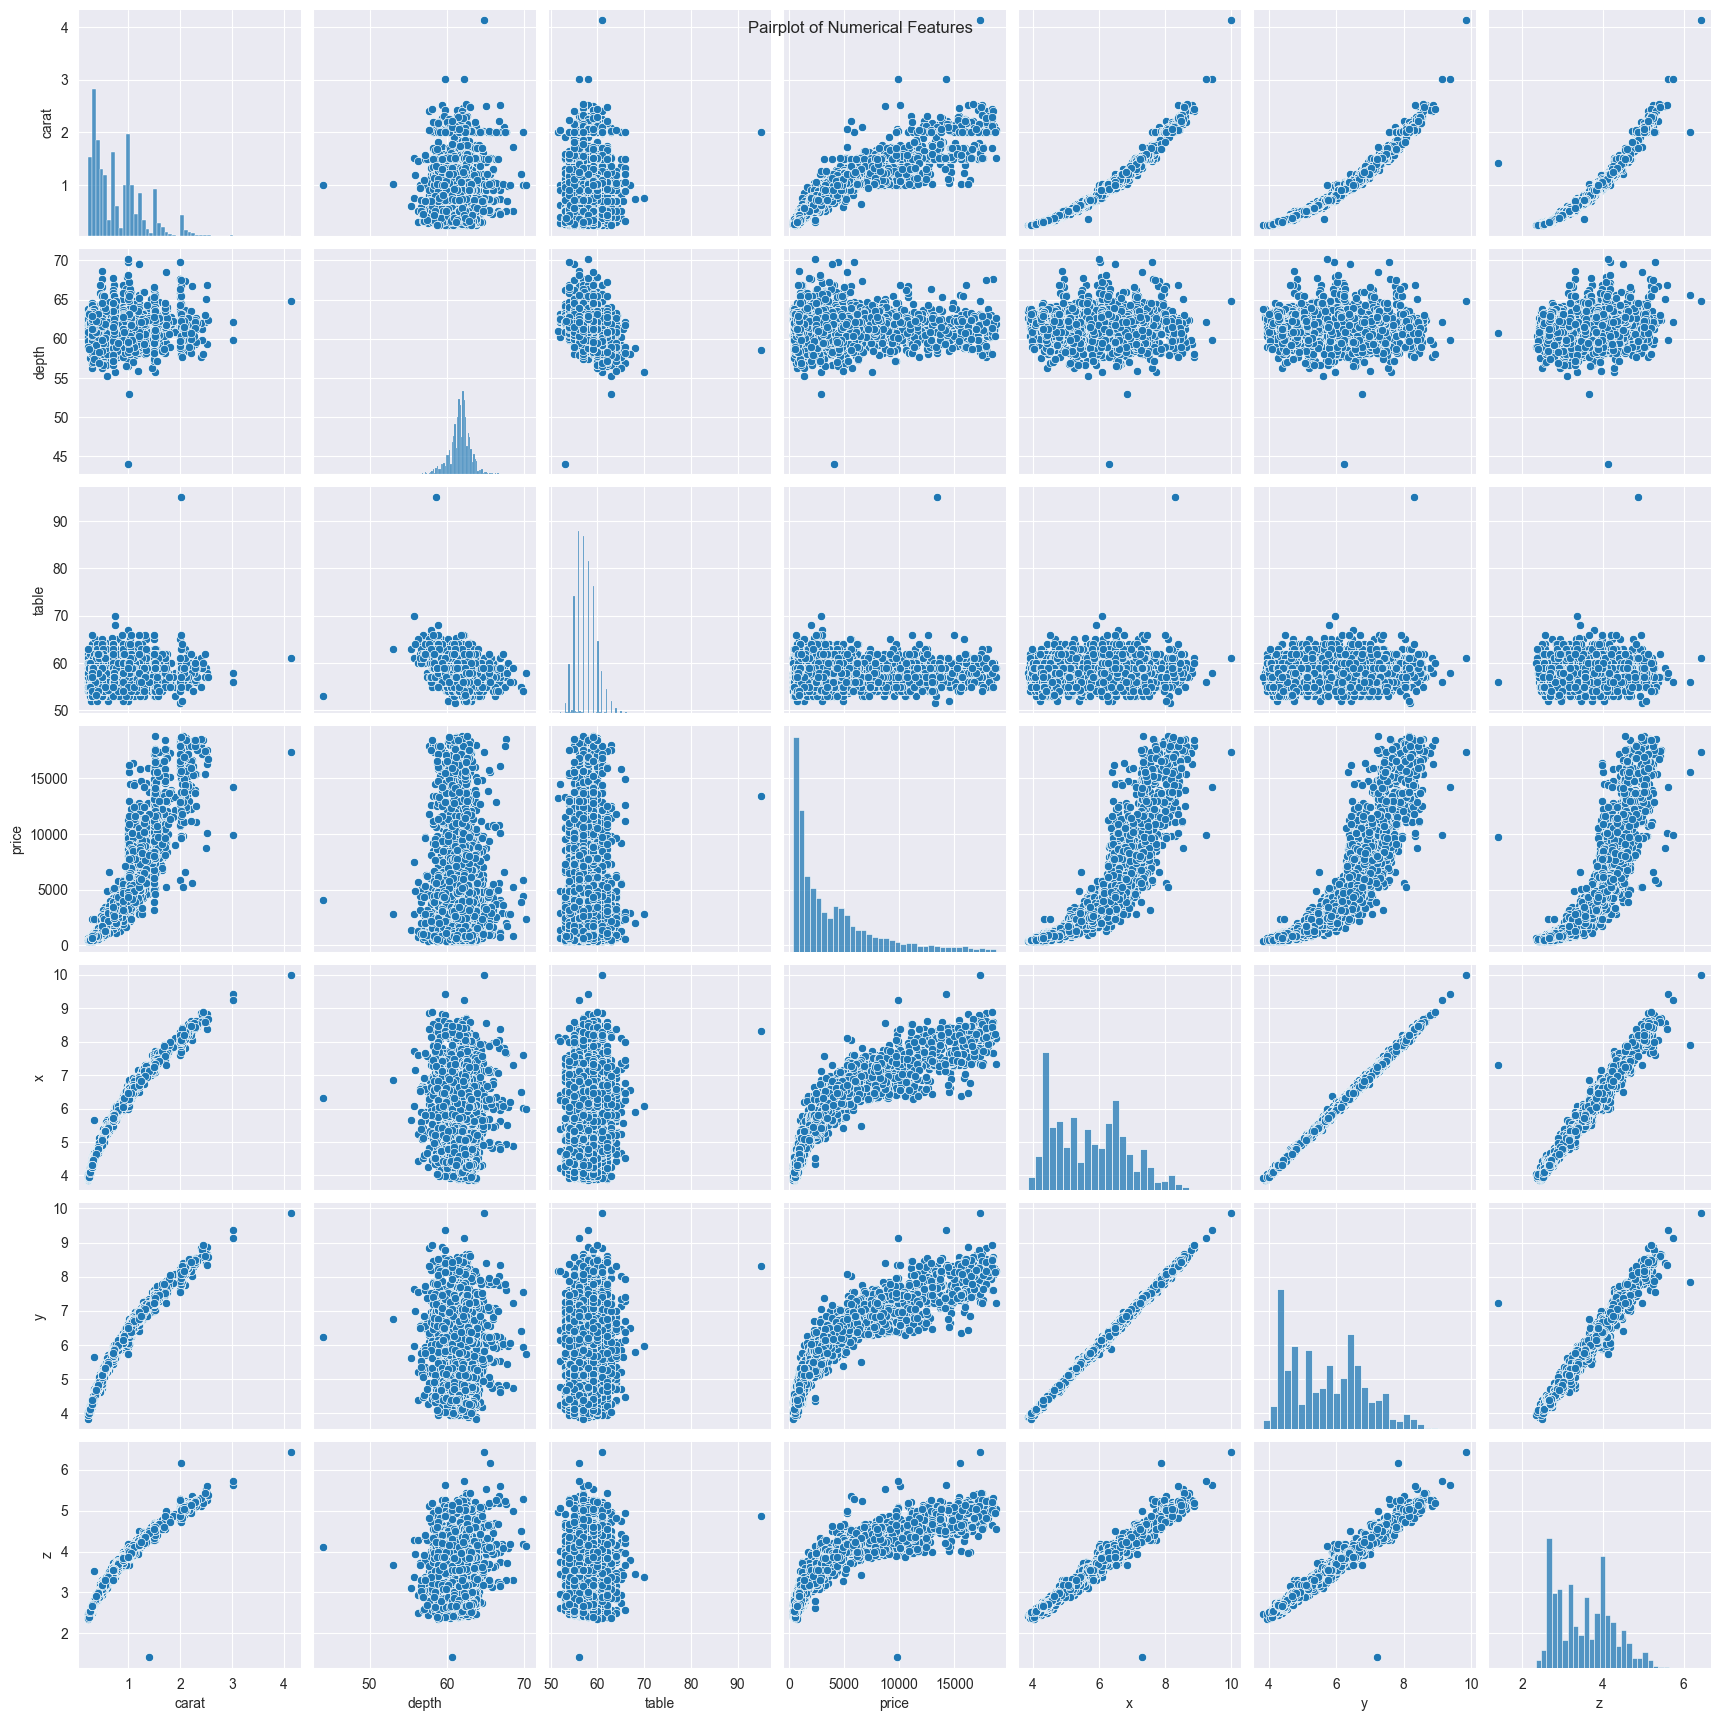

In [16]:
# Pairplot to visualize relationships between numerical features
sns.pairplot(df[numerical_features])
plt.suptitle('Pairplot of Numerical Features')
plt.show()

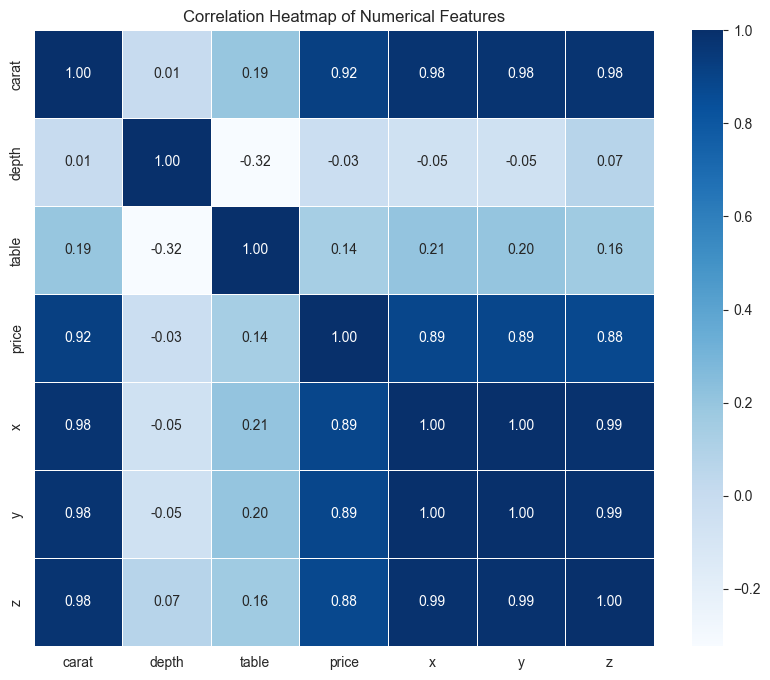

In [17]:
# Correlation matrix and heatmap
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

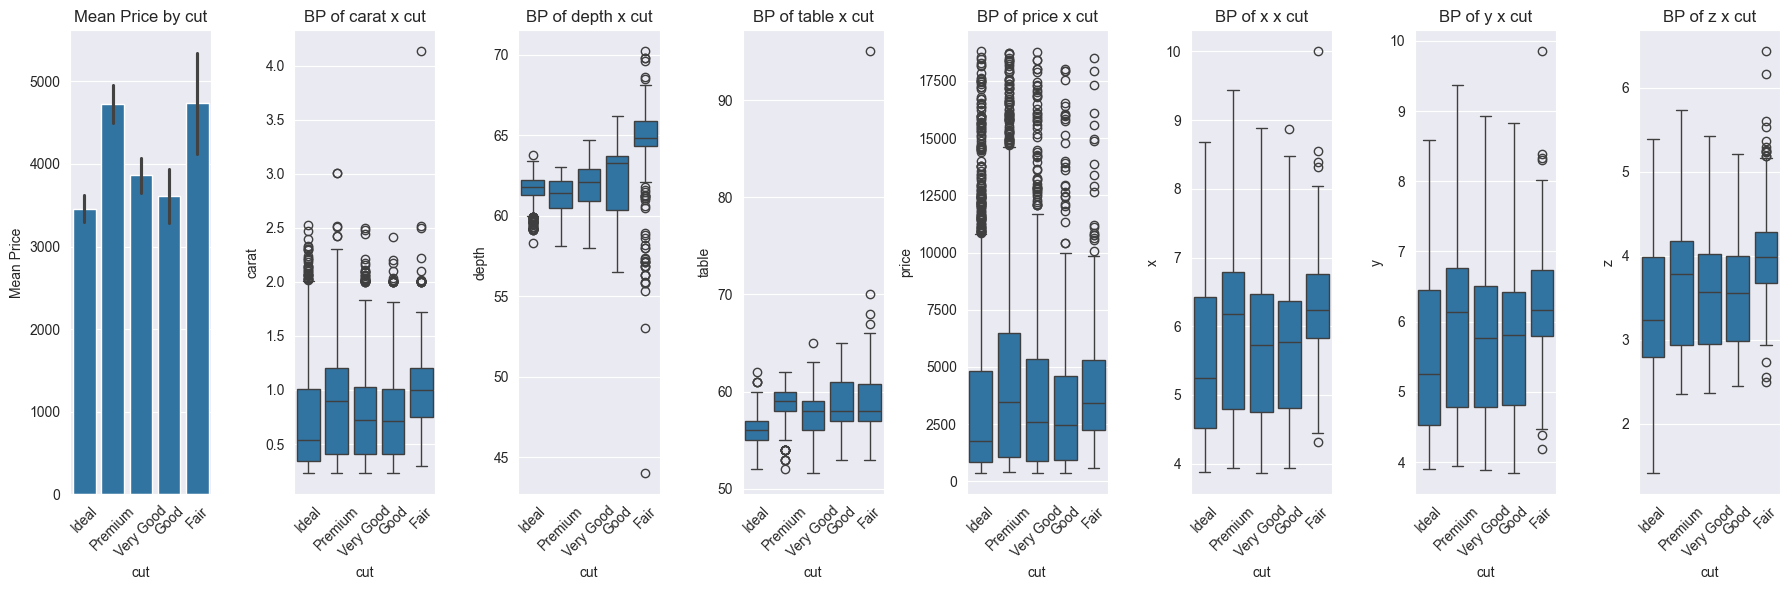

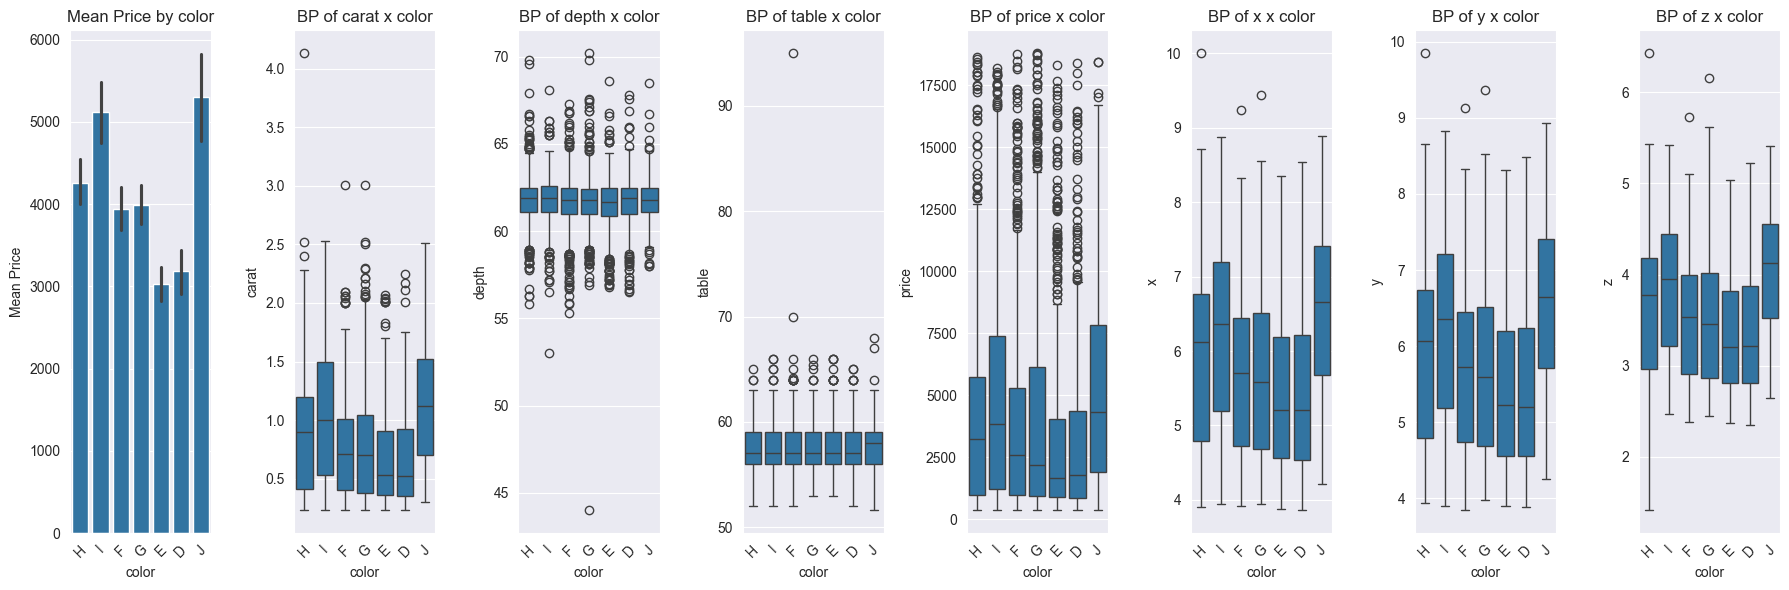

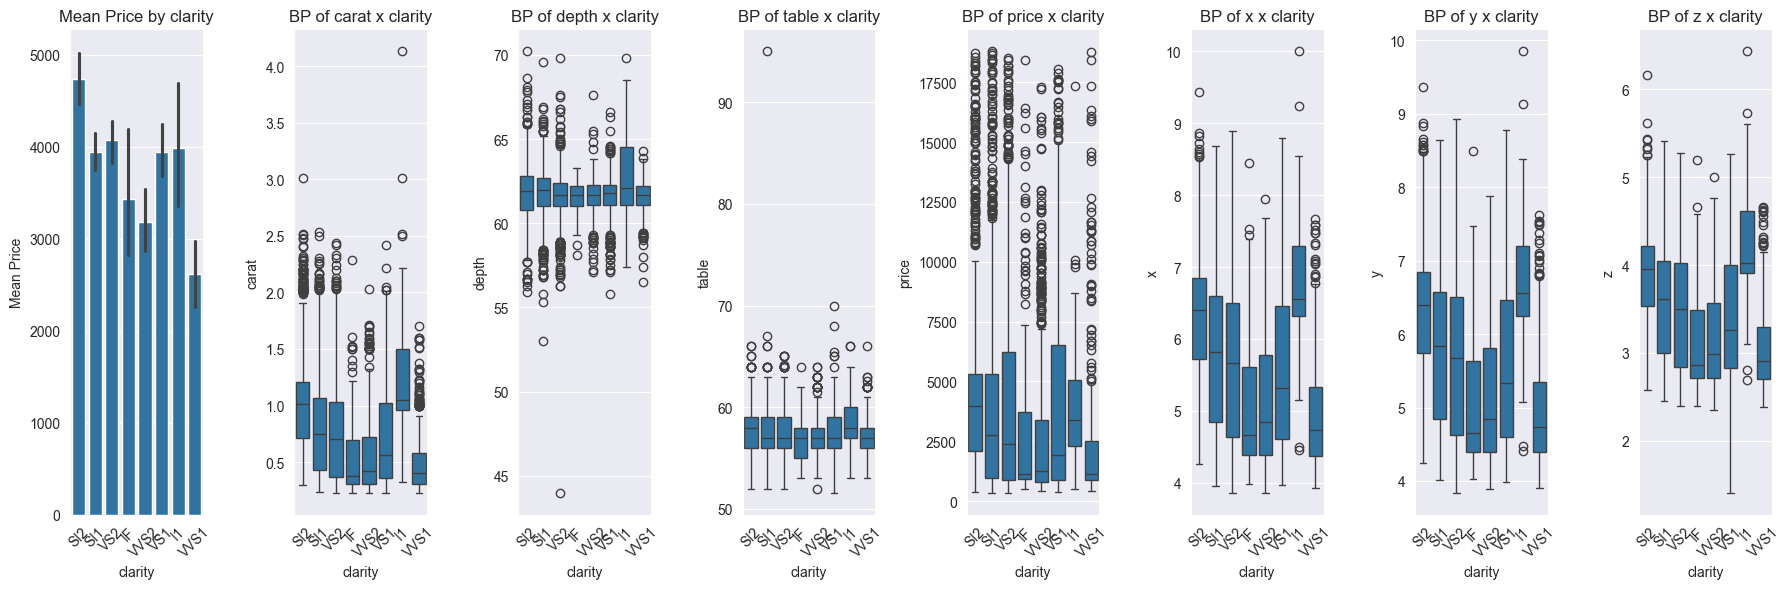

In [18]:
for cf in categorical_features:
    # Create subplots for each categorical feature
    fig, axes = plt.subplots(1, len(numerical_features) + 1, figsize=(18, 6))
    
    # Bar plot showing the mean of the target variable for each category
    sns.barplot(data=df, x=cf, y='price', ax=axes[0])
    axes[0].set_title(f'Mean Price by {cf}')
    axes[0].set_xlabel(cf)
    axes[0].set_ylabel('Mean Price')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels at 45 degree angle
    
    # Box plots showing the distribution of numerical features for each category
    for i, nf in enumerate(numerical_features, start=1):
        sns.boxplot(data=df, x=cf, y=nf, ax=axes[i])
        axes[i].set_title(f'BP of {nf} x {cf}')
        axes[i].set_xlabel(cf)
        axes[i].set_ylabel(nf)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels at 45 degree angle
    
    plt.tight_layout()
    plt.show()

# Training phase

Before we train the model, let's apply the one-hot encoding on the categorical features

In [19]:
# Define the order for encoding for each feature
cut_order = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

# Create a mapping dictionary for each feature
cut_mapping = {category: i+1 for i, category in enumerate(cut_order)}
color_mapping = {category: i+1 for i, category in enumerate(color_order)}
clarity_mapping = {category: i+1 for i, category in enumerate(clarity_order)}

# Map the categories to their encoded values in the DataFrame
df['cut_encoded'] = df['cut'].map(cut_mapping)
df['color_encoded'] = df['color'].map(color_mapping)
df['clarity_encoded'] = df['clarity'].map(clarity_mapping)

In [20]:
df.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,cut_encoded,color_encoded,clarity_encoded
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11,1,5,7
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35,1,5,6
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18,2,6,6
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50,1,3,6
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82,3,3,5
5,0.32,Ideal,G,IF,61.7,54.0,918,4.39,4.42,2.72,1,4,1
6,0.30,Very Good,H,IF,62.9,58.0,789,4.26,4.29,2.69,3,5,1
7,0.61,Ideal,E,VVS2,61.3,54.0,2823,5.51,5.59,3.40,1,2,3
8,2.01,Premium,G,SI2,61.2,57.2,18705,8.08,8.14,4.97,2,4,7
9,0.31,Ideal,I,VS1,61.2,55.0,507,4.37,4.39,2.68,1,6,4


We can start the training phase dividing the features (X) that will be used to reach the target variable (y). For the categorical features we'll be using the encoded ones.
The division stands with 70/30 respectively for the train set and the test set

In [21]:
random_number = random.randint(0, 4294967295)

# Define the features (X) removing the target variable and the categorical features, and target variable (y)
X = df.drop(columns=['price', 'cut', 'color', 'clarity'])
y = df['price']

# Split the dataset into training and testing sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_number)

# Check the shapes of the resulting sets
print("Shape of X train set:", X_train.shape)
print("Shape of y train set:", y_train.shape)
print("Shape of X test set:", X_test.shape)
print("Shape of y test set:", y_test.shape)

Shape of X train set: (3492, 9)
Shape of y train set: (3492,)
Shape of X test set: (1497, 9)
Shape of y test set: (1497,)


We'll test different models

In [22]:
# Initialize regression models
linear_regressor = LinearRegression()
random_forest_regressor = RandomForestRegressor(random_state=random_number)
gradient_boosting_regressor = GradientBoostingRegressor(random_state=random_number)
xgb_regressor = xgb.XGBRegressor(random_state=random_number)

# Fit (train) the different models on the training set
linear_regressor.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)
gradient_boosting_regressor.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)

timestamp_trained_model = datetime.now().strftime("%Y%m%d_%H%M%S")

Create a function to evaluate the model, the 3 metrics will bew RMSE, MAE and R2

In [23]:
# Evaluate the different models with different performance metrics
def evaluate_model(predictions, ground_truth):
    rmse = root_mean_squared_error(ground_truth, predictions)
    mae = mean_absolute_error(ground_truth, predictions)
    r_squared = r2_score(ground_truth, predictions)
    return rmse, mae, r_squared

Then we'll make prediction and evaluate them using the test sets

In [24]:
# Make predictions using the test set
linear_regressor_prediction = linear_regressor.predict(X_test)
random_forest_prediction = random_forest_regressor.predict(X_test)
gradient_boosting_prediction = gradient_boosting_regressor.predict(X_test)
xgb_prediction = xgb_regressor.predict(X_test)

linear_regressor_rmse, linear_reg_mae, linear_reg_r2 = evaluate_model(linear_regressor_prediction, y_test)
random_forest_rmse, random_forest_mae, random_forest_r2 = evaluate_model(random_forest_prediction, y_test)
gradient_boosting_rmse, gradient_boosting_mae, gradient_boosting_r2 = evaluate_model(gradient_boosting_prediction, y_test)
xgb_rmse, xgb_mae, xgb_r2 = evaluate_model(xgb_prediction, y_test)

We'll print the results and the random number used as seed for future reference and retaking

In [25]:
print(f'Seed used: {random_number}\n')

print(f'--- Linear Regression Performance ---\nRMSE: {linear_regressor_rmse:} - MAE: {linear_reg_mae:} - R2: {linear_reg_r2:}\n')

print(f'--- Random Forest Regression Performance ---\nRMSE: {random_forest_rmse:} - MAE: {random_forest_mae:} - R2: {random_forest_r2:}\n')

print(f'--- Gradient Boosting Regression Performance ---\nRMSE: {gradient_boosting_rmse:} - MAE: {gradient_boosting_mae:} - R2: {gradient_boosting_r2:}\n')

print(f'--- XGBoost Regression Performance ---\nRMSE: {xgb_rmse:} - MAE: {xgb_mae:} - R2: {xgb_r2:}')

Seed used: 3281579237

--- Linear Regression Performance ---
RMSE: 1151.2496530328822 - MAE: 803.8773286797199 - R2: 0.9164091122925794

--- Random Forest Regression Performance ---
RMSE: 687.2800739609685 - MAE: 341.72253173012695 - R2: 0.9702088397098054

--- Gradient Boosting Regression Performance ---
RMSE: 699.5059245942568 - MAE: 377.9602599160933 - R2: 0.9691395178464479

--- XGBoost Regression Performance ---
RMSE: 706.8160068369585 - MAE: 340.6829324338782 - R2: 0.9684911418546495


Print a scatter plot to show the difference between the different models

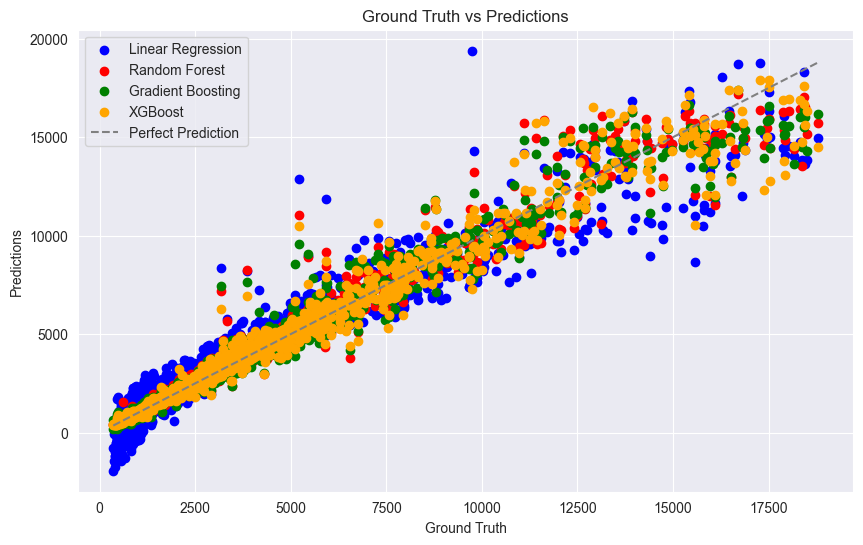

In [26]:
# Plot ground truth vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, linear_regressor_prediction, color='blue', label='Linear Regression')
plt.scatter(y_test, random_forest_prediction, color='red', label='Random Forest')
plt.scatter(y_test, gradient_boosting_prediction, color='green', label='Gradient Boosting')
plt.scatter(y_test, xgb_prediction, color='orange', label='XGBoost')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray', label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions')
plt.legend()
plt.show()

Let's calculate the confidence interval for xgboost predictions as it is the best model so far

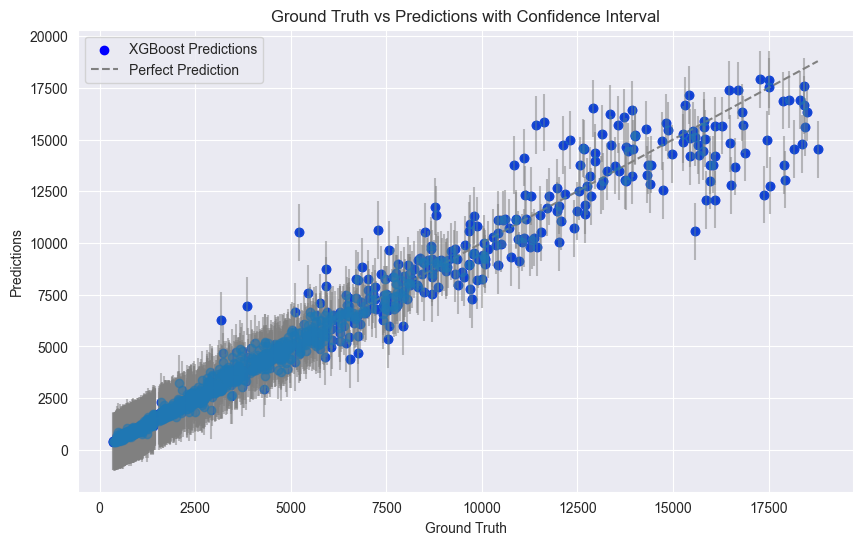

In [27]:
confidence_interval = 1.96 * xgb_rmse  # Consider a 95% confidence interval

# Plot ground truth vs predictions with confidence interval
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_prediction, color='blue', label='XGBoost Predictions')
plt.errorbar(y_test, xgb_prediction, yerr=confidence_interval, fmt='o', ecolor='gray', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray', label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions with Confidence Interval')
plt.legend()
plt.show()

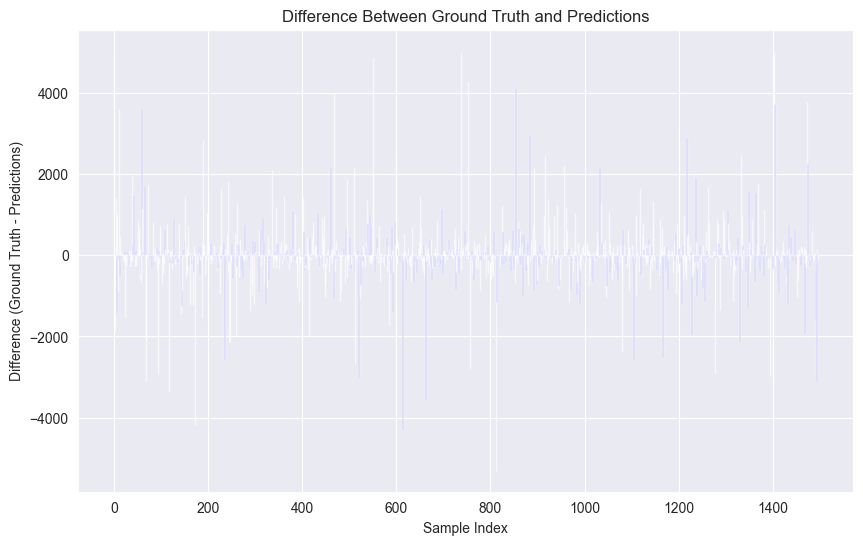

In [28]:
import numpy as np

# Calculate the difference between ground truth and predictions
difference = y_test - xgb_prediction

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(y_test)), difference, color='blue', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Difference (Ground Truth - Predictions)')
plt.title('Difference Between Ground Truth and Predictions')
plt.show()

We'll use the permutation importance technique to understand what are the most important features due respect of the results

In [29]:
result = permutation_importance(xgb_regressor, X_test, y_test, n_repeats=10, random_state=random_number, n_jobs=-1)

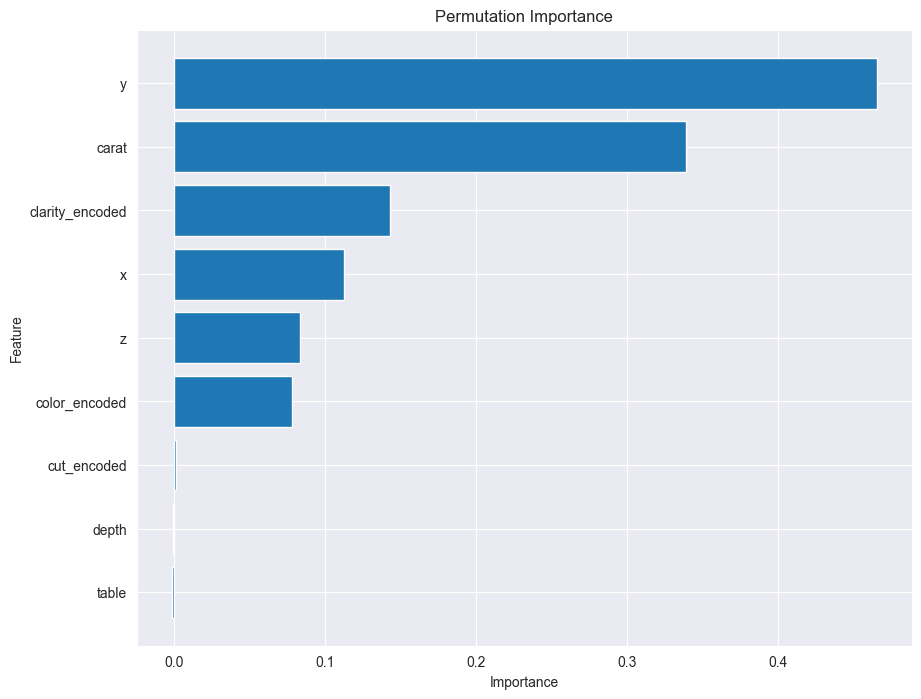

In [30]:
# Visualizza i risultati
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance')
plt.show()

In the end the best model is xgboost and the most important features are the dimensions of the diamond (is more important the width more than the table or the depth) and the carat so the weight. The clarity and the color are also important in the definition of the price

# Saving the weights of the model

In [31]:
xgb_regressor.save_model(f'xgboost_model_{timestamp_trained_model}.json')